In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.models import Sequential



# CSV 파일 불러오기
data = pd.read_csv("../merged_dataset/double_train/double_train.csv")
test_data = pd.read_csv("../extracted_keypoints/quickly_test/sj_type2_7.csv")

lr = 0.001
eps = 100

In [2]:
# 'Frame'열을 제외한 모든 열 선택
feature_columns = data.columns[1:-1]

# 입력 데이터(X)와 레이블(Y) 분리
X = data[feature_columns].values
Y = data['Label'].values

X_test = test_data[feature_columns].values
Y_test = test_data['Label'].values



# standardscaler로 데이터 정규화
scaler = StandardScaler()
scaler_test = StandardScaler()


X = scaler.fit_transform(X)
X_test = scaler_test.fit_transform(X_test)


X=X.astype(int)
Y=Y.astype(int)

X_test=X_test.astype(int)
Y_test=Y_test.astype(int)

C:\Users\KJW\AppData\Local\Temp\ipykernel_16340\1860177343.py:22: RuntimeWarning: invalid value encountered in cast
  X=X.astype(int)


In [3]:
# train-valid 데이터 분할 (80%, 20%)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [4]:
model = Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(27,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [5]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [6]:
# 데이터 형태 조정 (3D로 변환)
X_train_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_3d = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [7]:
history = model.fit(X_train_3d, Y_train, epochs=eps, batch_size=32, validation_data=(X_val_3d, Y_val))

Epoch 1/100
28/28 [==============================] - 1s 14ms/step - loss: 0.5287 - auc: 0.8710 - val_loss: 2374854.5000 - val_auc: 0.9051
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 0.3718 - auc: 0.9205 - val_loss: 2756672.7500 - val_auc: 0.9160
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 0.3195 - auc: 0.9355 - val_loss: 2395943.0000 - val_auc: 0.9363
Epoch 4/100
28/28 [==============================] - 0s 7ms/step - loss: 0.2919 - auc: 0.9460 - val_loss: 1723790.0000 - val_auc: 0.9404
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 0.2730 - auc: 0.9516 - val_loss: 1357103.8750 - val_auc: 0.9397
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 0.2604 - auc: 0.9555 - val_loss: 0.2883 - val_auc: 0.9508
Epoch 7/100
28/28 [==============================] - 0s 6ms/step - loss: 0.2427 - auc: 0.9574 - val_loss: 0.2832 - val_auc: 0.9514
Epoch 8/100
28/28 [==============================] -

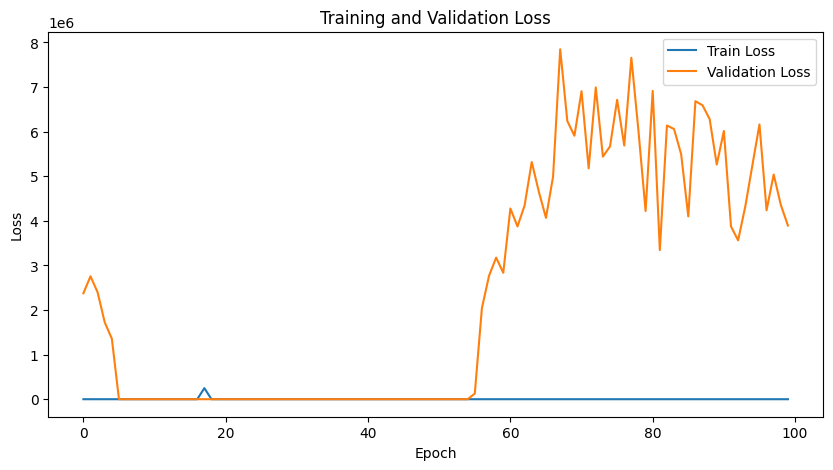

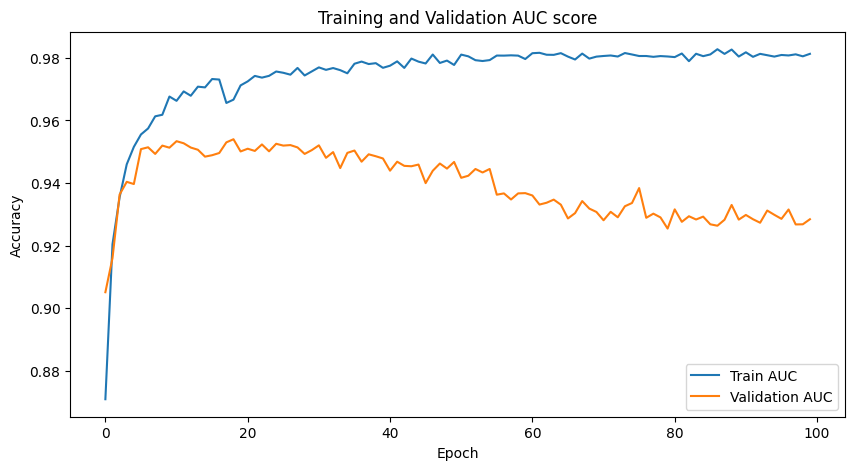

In [8]:
# 훈련 손실과 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig(f"plot/final_model_auc_{final_auc:.4f}_loss.png")  

# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC score')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig(f"plot/final_model_auc_{final_auc:.4f}_auc.png")

In [9]:
# 모델 평가

Y_prob = model.predict(X_test)

# 테스트 데이터 
_, AUC = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), Y_test)

# 임계값 설정
threshold = 0.5  # 예측된 확률이 0.5 이상이면 클래스를 1로 예측

# 예측된 확률을 클래스 레이블로 변환
Y_pred_binary = (Y_prob >= threshold).astype(int)

# Precision 계산
precision = precision_score(Y_test, Y_pred_binary)

# Recall 계산
recall = recall_score(Y_test, Y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print(f'Model AUC: {AUC}')

5/5 [==============================] - 0s 3ms/step - loss: 0.3875 - auc: 0.9513
Precision: 0.8923076923076924
Recall: 0.8169014084507042
Model AUC: 0.9513165354728699


In [10]:
# 테스트 데이터에 대한 예측 결과를 얻기 위해 모델 사용
predictions = model.predict(X_test)

# 이동 평균을 계산하여 예측값 부드럽게 만들기
smoothed_predictions = np.convolve(predictions.squeeze(), np.ones(5)/5, mode='same')

# 테스트 데이터에 대한 예측 결과를 바이너리 형태로 변환
binary_predictions = (smoothed_predictions > 0.5).astype(int)

5/5 [==============================] - 0s 2ms/step


In [11]:
# 0에서 1로 바뀌는 구간에서 줄넘기 개수 카운트
jump_count = np.sum(np.diff(binary_predictions.flatten()) > 0)

In [12]:
# 테스트 데이터의 점프수
print(f'Predicted Jump Count: {jump_count}')


Predicted Jump Count: 7


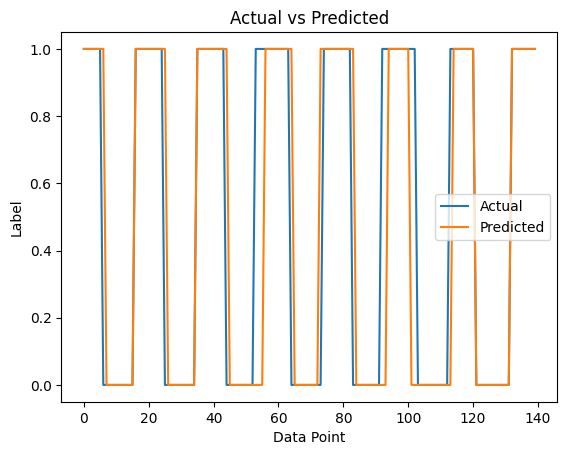

In [13]:
# 테스트 데이터 1에 대한 예측 결과

plt.plot(Y_test, label='Actual')
plt.plot(binary_predictions.flatten(), label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Data Point')
plt.ylabel('Label')
plt.legend()
plt.show()